### Purpose
1. Simulation of DWI data obtained with different b values
2. ADC fitting in the presence of partial volume effect and Rician noise

In [2]:
addprocs(Sys.CPU_CORES-nprocs());
nprocs()

28

### Loading juila packages
__NOTE__: You need to run `Pkg.add("LsqFit")` only once in the HPC

In [4]:
push!(LOAD_PATH,"library");
using Read_NIfTI1_real
using PyPlot
using NK_tools
Pkg.add("LsqFit") # You can remove this line after running it once in HPC
@everywhere using LsqFit

### Loading NIFTI data

To save time, we are only looking at 15 slices: slice #36 to slice #50


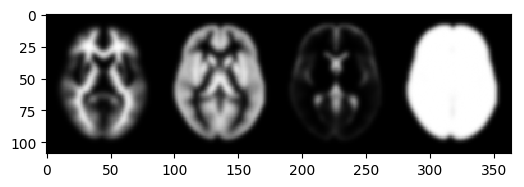

In [5]:
filename = "data/avg152T1_white_littleEndian.nii.gz"
headerinfo = load_niigz_header(filename); # see the source code in library/Read_NIfTI1_real.jl
dataWM = load_niigz_data(filename, headerinfo); # see the source code in library/Read_NIfTI1_real.jl
filename = "data/avg152T1_gray_littleEndian.nii.gz"
headerinfo = load_niigz_header(filename); # see the source code in library/Read_NIfTI1_real.jl
dataGM = load_niigz_data(filename, headerinfo); # see the source code in library/Read_NIfTI1_real.jl
filename = "data/avg152T1_csf_littleEndian.nii.gz"
headerinfo = load_niigz_header(filename); # see the source code in library/Read_NIfTI1_real.jl
dataCSF = load_niigz_data(filename, headerinfo); # see the source code in library/Read_NIfTI1_real.jl

# we only look at 15 selected slices; just to save time
dataWM = flipdim(permutedims(dataWM[:,:,36:50,:],[2 1 3 4]),1);
dataGM = flipdim(permutedims(dataGM[:,:,36:50,:],[2 1 3 4]),1);
dataCSF = flipdim(permutedims(dataCSF[:,:,36:50,:],[2 1 3 4]),1);

xdim,ydim,zdim=size(dataWM);
dataGM = convert(Array{Float64},dataGM);
dataWM = convert(Array{Float64},dataWM);
dataCSF = convert(Array{Float64},dataCSF);
dataSUM = dataGM + dataWM + dataCSF;
mask = dataSUM.>0.;
figure(1); figure(figsize=(6,3)); imshow(hcat(dataWM[:,:,4,1],dataGM[:,:,4,1],dataCSF[:,:,4,1],dataSUM[:,:,4,1]),cmap="gray")
L_inside = find(mask);
L_outside = find(dataSUM.==0.);


### Simulating DWI data corresponding to different b values
Based on Denis Le Bihan JOURNAL OF MAGNETIC RESONANCE IMAGING 13:534–546 (2001), we assume:
* The mean diffusivity of CSF = $ 3.19 \times 10^{-3} \frac{{mm}^2}{s} $ 
* The mean diffusivity of GM = $ 0.83 \times 10^{-3} \frac{{mm}^2}{s} $ 
* The mean diffusivity of WM = $ 0.69 \times 10^{-3} \frac{{mm}^2}{s} $ 

We produce 12 sets of simulated images corresponding to b values ranging from 0 to 2200 $\frac{s}{mm^2} $

The signals are simulated based on $ S = S_0\exp(-bD) $


In [6]:
# First, produce images without noise

MD_CSF = 3.19e-3;
MD_GM = 0.83e-3;
MD_WM = 0.69e-3;

bValues = [0.,200.,400.,600.,800.,1000.,1200.,1400.,1600.,1800.,2000.,2200.]
number_of_DWI = size(bValues)[1]
MRIdata = zeros(Float64,xdim,ydim,zdim,number_of_DWI);
for cnt = 1: number_of_DWI
    b = bValues[cnt]
    csfTmp = dataCSF.*exp(-b*MD_CSF)
    wmTmp = dataWM.*exp(-b*MD_WM)
    gmTmp = dataGM.*exp(-b*MD_GM)
    sumTmp = csfTmp + wmTmp + gmTmp
    MRIdata[:,:,:,cnt] = sumTmp;
end

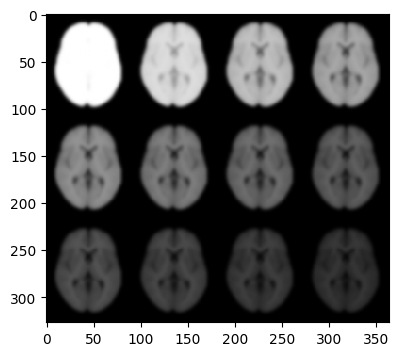

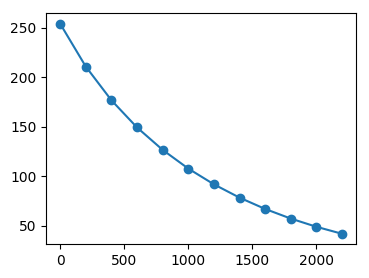

952224

In [7]:
figure(1); figure(figsize=(6,4)); imal(MRIdata[:,:,4,:],4,3);
figure(2); figure(figsize=(4,3)); plot(bValues, MRIdata[40,40,4,:],"-o");

### Fitting ADC

In [13]:
@everywhere DWImodel(b,p) = p[2]*exp.(-b.*p[1]);
ADCmap = SharedArray{Float64,3}((xdim,ydim,zdim));

@time @sync @parallel for cntz = 1:zdim
    for cnty = 1:ydim
        for cntx = 1:xdim
            if MRIdata[cntx,cnty,cntz,1]>0
                fit = curve_fit(DWImodel, bValues, MRIdata[cntx,cnty,cntz,:], [1e-3,300])
                ADCmap[cntx,cnty,cntz]=fit.param[1]
            end
        end
    end
end
;

  1.282782 seconds (76.46 k allocations: 4.035 MiB)


0.000713327147481675

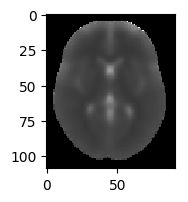

In [20]:
figure(figsize=(4,2)); imshow(ADCmap[:,:,4],cmap="gray",interpolation="none"); 
display(ADCmap[25,30,4])

### Simulation of images affected by Rician noise 

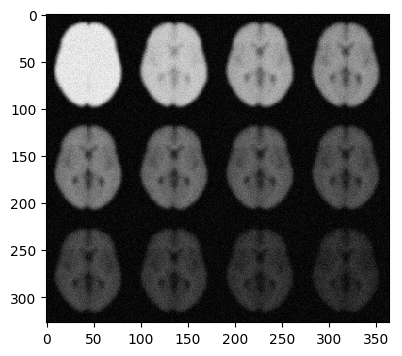

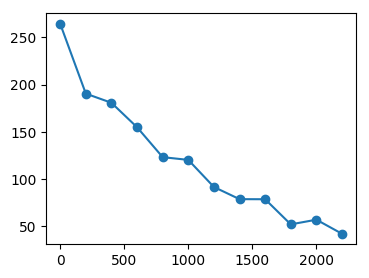

952224

In [12]:
ScaleConstant = 8.;
noiseRealPart = ScaleConstant*randn(Float64,xdim,ydim,zdim,number_of_DWI);
noiseImagPart = ScaleConstant*randn(Float64,xdim,ydim,zdim,number_of_DWI);
noiseMag = (noiseRealPart.^2+ noiseImagPart.^2).^0.5
RealPart = MRIdata;
ImagPart = zeros(size(MRIdata));
MRIdataNoise = ((RealPart+noiseRealPart).^2+(ImagPart+noiseImagPart).^2).^0.5
figure(1); figure(figsize=(6,4)); imal(MRIdataNoise[:,:,4,:],4,3);
figure(2); figure(figsize=(4,3)); plot(bValues, MRIdataNoise[40,40,4,:],"-o");

### Fitting ADC from noisy images

In [14]:
@everywhere DWImodel(b,p) = p[2]*exp.(-b.*p[1]);
ADCmapNoise = SharedArray{Float64,3}((xdim,ydim,zdim));

@time @sync @parallel for cntz = 1:zdim
    for cnty = 1:ydim
        for cntx = 1:xdim
            if MRIdata[cntx,cnty,cntz,1]>0
                fit = curve_fit(DWImodel, bValues, MRIdataNoise[cntx,cnty,cntz,:], [1e-3,300])
                ADCmapNoise[cntx,cnty,cntz]=fit.param[1]
            end
        end
    end
end
;

  1.775234 seconds (76.60 k allocations: 4.023 MiB)


0.0007346493263759418

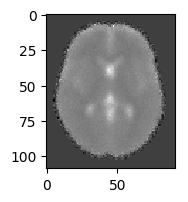

In [19]:
figure(figsize=(4,2)); imshow(ADCmapNoise[:,:,4],cmap="gray",interpolation="none"); 
display(ADCmapNoise[25,30,4])